# Autoencoder Development

#### 1. Dependencies


Library imports.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback

#### 2. Data Loading & Feature Engineering

Loading provided datasets.

In [1]:
dset1 = np.load("subset_1.npy")
dset2 = np.load("subset_2.npy")
dset3 = np.load("subset_3.npy")
full = np.concatenate((dset1, dset2, dset3), axis=0)

# Obtain numpy array of flattened representations.
x_train, x_test = train_test_split(full, test_size=0.2, random_state=42)

# Normalising pixel colour values.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Obtain colour image representations for convolutional models.
x_train_conv, x_test_conv = np.reshape(x_train, (956, 150, 225, 3)), np.reshape(x_test, (240, 150, 225, 3))



NameError: name 'np' is not defined

Displaying datasets for initial testing purposes only.

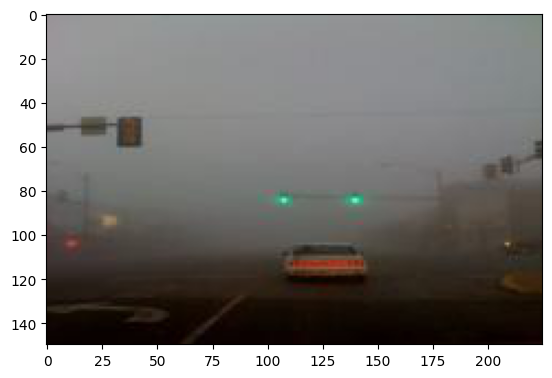

In [ ]:
i = 600
plt.imshow(np.reshape(full[i, :], (150, 225, 3)))

Defining latent dimension and compression ratio. Note, all of our inputs have the same shape (400, 101250), meaning our flattened input dimension is 101250. We will be using the flattened representation for all other models except for the Deep CAE, so our initial choice of latent dimension will be the square root of the latent dimension, that is ~300.

Note: the above consideration may need to be amended since all of our models make use of convolutional layers, and so therefore won't use the flattened representation?

In [ ]:
flattened_shape = x_test.shape[1:]
image_shape = x_test_conv.shape[1:]

Data engineering and cleaning functions for basic deep CAE.

Data engineering and cleaning functions for basic deep CVAE.

In [ ]:
# Outlier detection and removal.



Data engineering and cleaning functions for novel architecture.

Defining train-test split.

#### 3. Model Development

Note that all subsections will include a model definition, hyperparameter tuning specific to that model and optimisers for each model. The final subsection will be strictly for model fitting.

Definition of simple deep autoencoder with multiple fully connected layers for encoder and decoder. This is purely for demonstrating usage of the model subclassing API in the construction of a generic autoencoder architecture, NOT to be included in the final comparison of three models in the report.

In [ ]:
class AE(Model):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

        self.encoder = tf.keras.Sequential([
            layers.Dense(1024, activation='relu'),
            layers.Dense(512, activation='linear'),
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(1024, activation='relu'),
            layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



Definition of basic deep convolutional autoencoder. 

In [ ]:
class LossHistory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Appending loss to the history after each epoch
        loss_value = logs.get("loss")
        self.model.reconstruction_losses.append(loss_value)


class CAE(Model):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

        self.encoder = tf.keras.Sequential([
            layers.ZeroPadding2D(padding=((1, 1), (3, 4)), input_shape=self.shape),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),  
            layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),  
        ])

        self.decoder = tf.keras.Sequential([
            layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'),
            layers.Cropping2D(cropping=((1, 1), (3, 4)))
        ])

        self.reconstruction_losses = []

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def compute_loss(self, x, y, y_pred, sample_weight=None):
        return tf.keras.losses.MeanSquaredError()(y, y_pred)
    
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compute_loss(x, y, y_pred)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        for metric in self.metrics:
            if metric.name == "loss":
                metric.update_state(loss)
            else:
                metric.update_state(y, y_pred)
        
        return {m.name: m.result() for m in self.metrics}



Definition of deep convolutional variational autoencoder with optimisation considerations based on the paper linked in Obsidian notes.

In [ ]:
class Sampling(Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = tf.keras.random.SeedGenerator(1337)

    def call(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + tf.keras.ops.exp(0.5 * z_log_var) * epsilon
        

class VEncoder(Model):
    def __init__(self, shape, latent_dim):
        super().__init__()
        self.shape = shape
        self.latent_dim = latent_dim

        self.convolutions = tf.keras.Sequential([
            layers.Conv2D(32, 3, activation='relu', strides=2, padding='same', input_shape=self.shape),
            layers.Conv2D(64, 3, activation='relu', strides=2, padding='same'),
            layers.Conv2D(128, 3, activation='relu', strides=2, padding='same'),
            layers.Conv2D(256, 3, activation='relu', strides=2, padding='same'),
            layers.Flatten(),
            layers.Dense(512, activation='relu'),  
            layers.Dense(latent_dim, activation='leaky_relu')
        ])

        self.z_mean = layers.Dense(latent_dim, name='z_mean')
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')
        self.sampling = Sampling()

    def call(self, x):
        conv = self.convolutions(x)
        z_mean = self.z_mean(conv)
        z_log_var = self.z_log_var(conv)
        z = self.sampling(z_mean, z_log_var)
        return z_mean, z_log_var, z

class VDecoder(Model):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

        self.decoder = tf.keras.Sequential([
            layers.Dense(4 * 4 * 1024, activation='relu'),
            layers.Reshape((4, 4, 1024)),
            layers.Conv2DTranspose(512, 3, activation='relu', strides=2, padding='same'),
            layers.Conv2DTranspose(256, 3, activation='relu', strides=2, padding='same'),
            layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same'),
            layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same'),
            layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same'),
            layers.Lambda(lambda x: tf.image.resize(x, (150, 225))),
            layers.Conv2D(3, 3, activation='sigmoid', padding='same')
        ])


    def call(self, x):
        return self.decoder(x)
    
class VAE(Model):
    def __init__(self, shape, latent_dim=1024):
        super().__init__()
        self.encoder = VEncoder(shape, latent_dim)
        self.decoder = VDecoder(shape)
        self.z_mean = None
        self.z_log_var = None
        self.reconstruction_losses = []

    def call(self, inputs):
        self.z_mean, self.z_log_var, z = self.encoder(inputs)
        decoded = self.decoder(z)
        return decoded

    # TO DO: Need to implement this.
    def perceptual_loss(self, y, y_pred):
        pass

    def compute_loss(self, x, y, y_pred, sample_weight=None):
        # Standard reconstructive loss.
        reconstruction_loss = tf.keras.losses.MeanSquaredError()(y, y_pred)
        # Reconstructive loss as perceptual loss based on above method.
        kl_loss = -0.5 * tf.reduce_mean(1 + self.z_log_var - tf.square(self.z_mean) - tf.exp(self.z_log_var))
        return reconstruction_loss + kl_loss

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compute_loss(x, y, y_pred)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        for metric in self.metrics:
            if metric.name == "loss":
                metric.update_state(loss)
            else:
                metric.update_state(y, y_pred)
        
        return {m.name: m.result() for m in self.metrics}



Definition of [Residual Cascade Decoders-Based Autoencoder](https://arxiv.org/pdf/2107.00002).

Fitting selected model

In [ ]:
model = VAE(image_shape)
model.compile(optimizer='adam')
loss_history = LossHistory()
model.fit(x_train_conv, x_train_conv, epochs=50, shuffle=True, validation_data=(x_test_conv, x_test_conv), callbacks=loss_history)

'''
z = None
model = CAE(image_shape)
model.compile(optimizer='adam')
loss_history = LossHistory()
model.fit(x_train_conv, x_train_conv, epochs=10, shuffle=True, validation_data=(x_test_conv, x_test_conv), callbacks=loss_history)
'''

/home/thomast/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-14 13:12:23.517366: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78643200 exceeds 10% of free system memory.
2025-03-14 13:12:23.531074: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78643200 exceeds 10% of free system memory.
2025-03-14 13:12:23.535598: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78643200 exceeds 10% of free system memory.
2025-03-14 13:12:23.601633: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 387180000 exceeds 10% of free system memory.
2025-03-14 13:12:23.697787: W external/l

Epoch 1/50


#### 4. Model Evaluation

This section could include:

* Testing of models trained
* Generation of results

Plotting reconstruction loss.

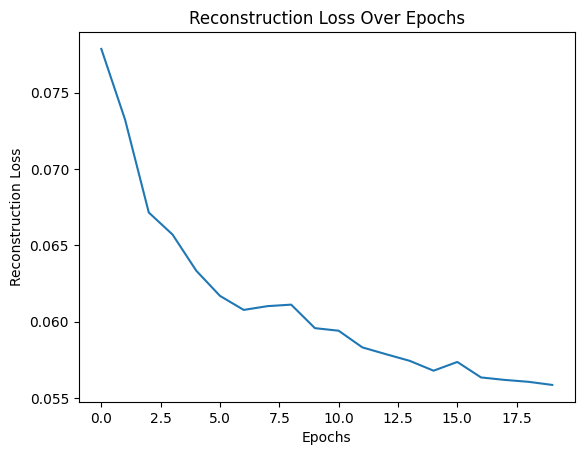

In [ ]:
plt.plot(model.reconstruction_losses)
plt.title("Reconstruction Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Reconstruction Loss")
plt.show()

Generic visual testing of selected model.

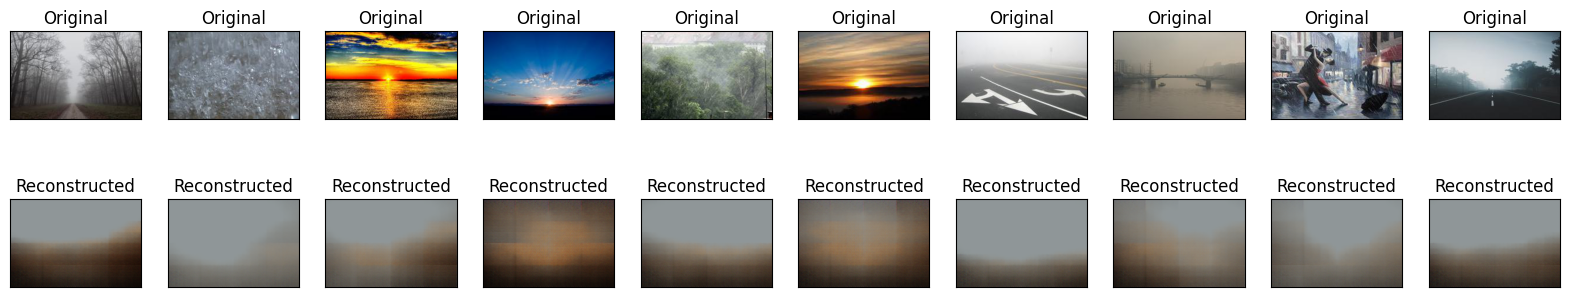

In [ ]:
z_mean, z_log_var, z = model.encoder(x_test_conv)
z = z.numpy()
#encoded = model.encoder(x_test_conv)
decoded_imgs = model.decoder(z).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  
  # Display input image.
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(np.reshape(x_test[i], (150, 225, 3)))
  plt.title("Original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # Display reconstructed image.
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(np.reshape(decoded_imgs[i], (150, 225, 3)))
  plt.title("Reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()


#### 5. Figure Creation


Basic comparison table for each model.

Analysis of basic deep CAE.

Analysis of basic deep CVAE.

Latent space visualisation with PCA and t-SNE.

(240, 512)
(240, 3)


/tmp/ipykernel_24592/1325998487.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(z_tsne[:, 0], z_tsne[:, 1], z_tsne[:, 2], cmap='viridis')
/tmp/ipykernel_24592/1325998487.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.colorbar(ax.scatter(z_tsne[:, 0], z_tsne[:, 1], z_tsne[:, 2], cmap='viridis'))


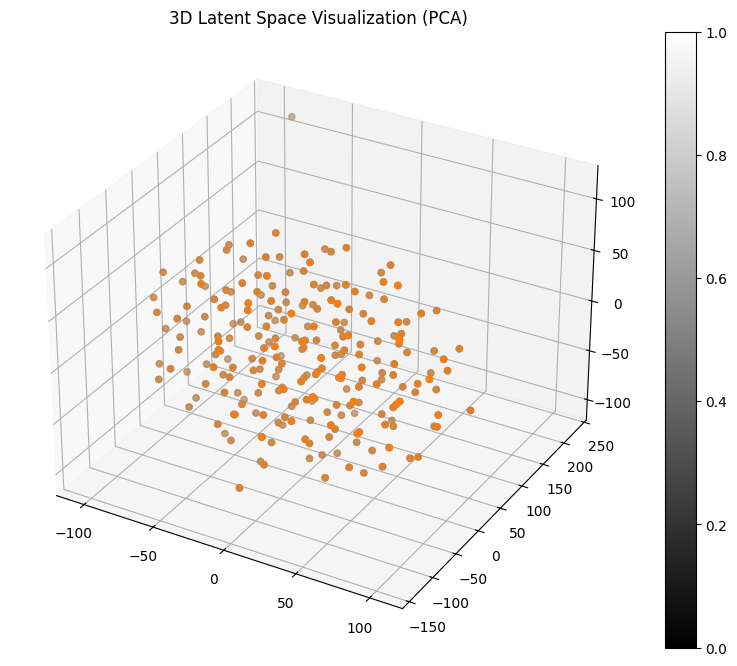

In [ ]:
from sklearn.manifold import TSNE

# First reduce our latent vector.
print(z.shape)

## Approach 1: PCA.
if z is not None:
    pca = PCA(n_components=3)
    z_pca = pca.fit_transform(z)
    print(z_pca.shape)

## Approach 2: t-SNE

tsne = TSNE(n_components=3, random_state=42)
z_tsne = tsne.fit_transform(z)


# Visualise reduced latent space.

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(z_tsne[:, 0], z_tsne[:, 1], z_tsne[:, 2], cmap='viridis')


ax.set_title("3D Latent Space Visualization (PCA)")

plt.colorbar(ax.scatter(z_tsne[:, 0], z_tsne[:, 1], z_tsne[:, 2], cmap='viridis'))

plt.show()

Analysis of cascade decoder-based autoencoder.